# Partitioning with Known and Unknown Lengths

The Context API allows you to specify when the lengths of the partitions are public and when they aren't. This section will clarify the trade-offs of partitioning with known and unknown lengths. 

## Set Up

In [2]:
import polars as pl 
import opendp.prelude as dp
import seaborn as sns 
import matplotlib.pyplot as plt

dp.enable_features("contrib")
sns.set_theme(style='darkgrid')

In [3]:
![ -e sample_FR_LFS.csv ] || ( curl 'https://github.com/opendp/dp-test-datasets/blob/main/data/sample_FR_LFS.csv.zip?raw=true' --location --output sample_FR_LFS.csv.zip; unzip sample_FR_LFS.csv.zip )

# Many columns contain mixtures of strings and numbers and cannot be parsed as floats,
# so we'll set `ignore_errors` to true to avoid conversion errors. 

df = pl.scan_csv("sample_FR_LFS.csv", ignore_errors=True)

# For a loose upper bound we'll take the population of France.

estimated_max_partition_len = 60_000_000

## Grouping By Private Lengths

The `public_info` parameter determines which properties of the grouped data are considered public information. 

There are two possible values: 

- `keys`: Indicates that keys are public. 
- `lengths`: Indicates that both keys and partition lengths are public. 

To group by private keys, set the `public_info` parameter to `keys`. The group identifiers are treated as public information, and the partition length is protected. This allows queries that depend on count to be run and satisfy a DP guarantee:


In [ ]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
    margins={
        ("YEAR", ): dp.polars.Margin(public_info="keys",
                              max_partition_length=estimated_max_partition_len, 
                              max_partition_contributions=4, 
                              max_num_partitions=1),
        (): dp.polars.Margin(public_info="lengths",
                      max_partition_length=estimated_max_partition_len, 
                      max_num_partitions=1),
    },
)

If the `public_info` for the "YEAR" `Margin` were set to `lengths`, the following query would fail because the partition length would be considered public and the DP mechanisms would not provide an adequate guarantee. 

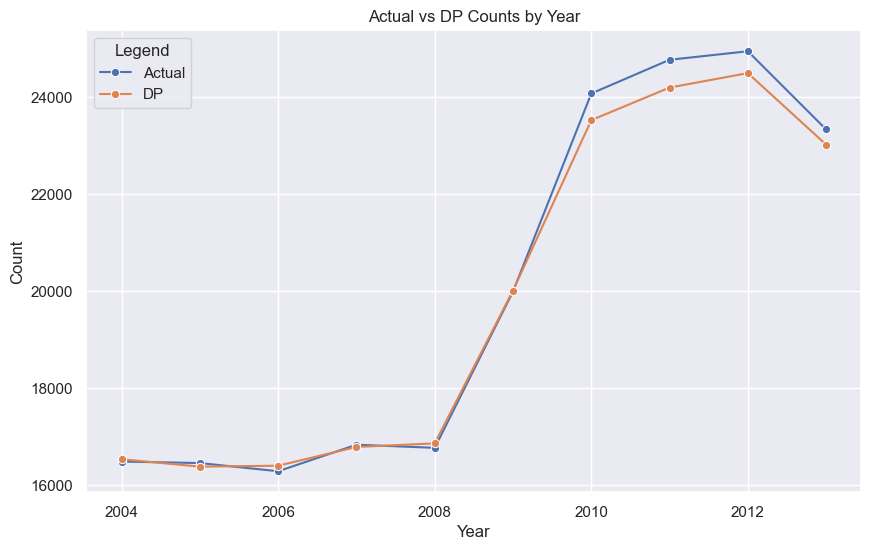

In [4]:
count_year_actual = (
    df.group_by("YEAR").agg(
        pl.len().alias("Actual Count")
    ).sort("YEAR")
).collect()

count_year_dp = (
    context.query().group_by("YEAR").agg(
        pl.len().dp.noise().alias("DP Count")
    ).sort("YEAR")
).release().collect()

plt.figure(figsize=(10, 6))
sns.lineplot(x=count_year_actual["YEAR"].to_list(), y=count_year_actual["Actual Count"].to_list(), marker="o", label="Actual")
sns.lineplot(x=count_year_dp["YEAR"].to_list(), y=count_year_dp["DP Count"].to_list(), marker="o", label="DP")
plt.title('Actual vs DP Counts by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Legend')
plt.show()

However, in scenarios, such as computing the `sum`, that do not depend on the partition length being public, the query that still specifies the lengths to be public will have a higher utility due to more information being available at the cost of less privacy. 

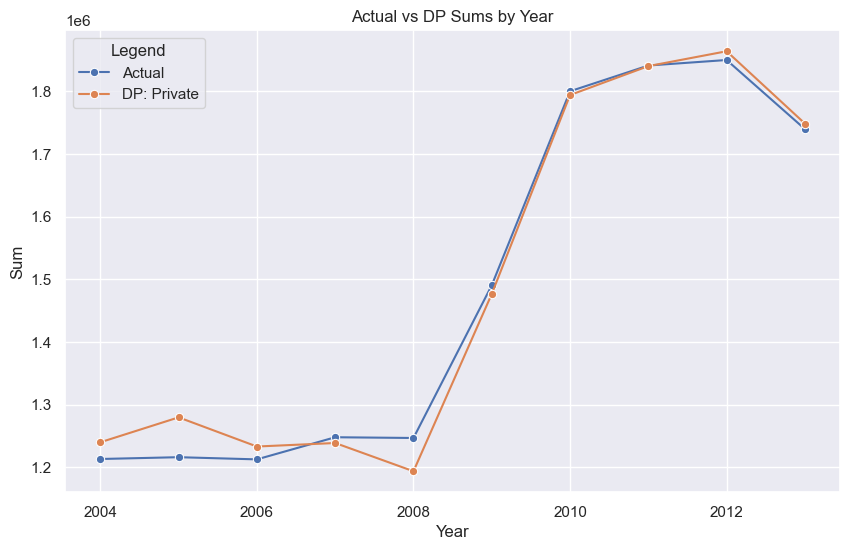

In [5]:
sum_year_actual = (df.group_by("YEAR").agg(pl.col("HWUSUAL").sum().alias("Actual Sum")).sort("YEAR")).collect()

sum_year_dp = (
    context.query().group_by("YEAR").agg(
        pl.col("HWUSUAL").fill_null(40.).dp.sum((0,100)).alias("DP Sum")
    ).sort("YEAR")).release().collect()

plt.figure(figsize=(10, 6))
sns.lineplot(x=sum_year_actual["YEAR"].to_list(), y=sum_year_actual["Actual Sum"].to_list(), marker="o", label="Actual")
sns.lineplot(x=sum_year_dp["YEAR"].to_list(), y=sum_year_dp["DP Sum"].to_list(), marker="o", label="DP: Private")
plt.title('Actual vs DP Sums by Year')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.legend(title='Legend')
plt.show()

## Grouping By Public Lengths

Queries whose functions don't depend on the partition length may not have a significantly different utility if the `public_info` parameter is public or private. 

One example scenario is the sum of total hours worked per year where the data is being aggregated over a specific key and the noise addition is independent of the partition lengths being revealed. 

However, be cautious when you allow the parameter to be public and enable it to be public only in settings where you are confident the partition length will not reveal any sensitive information. 


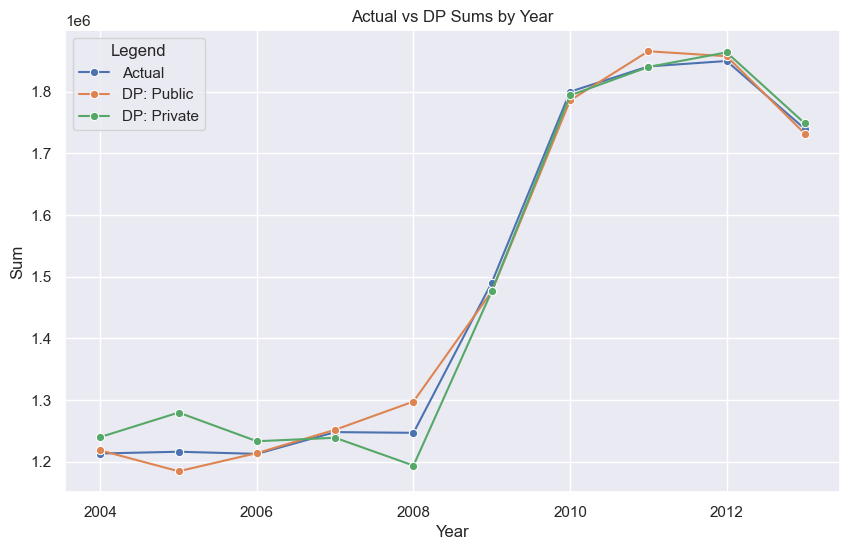

In [6]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
    margins={
        ("YEAR", ): dp.polars.Margin(public_info="lengths",
                              max_partition_length=estimated_max_partition_len, 
                              max_partition_contributions=4, 
                              max_num_partitions=1),
                    
        (): dp.polars.Margin(public_info= "lengths",
                      max_partition_length=estimated_max_partition_len, 
                      max_num_partitions=1),
    },
)

sum_year_dp_public = (
    context.query().group_by("YEAR").agg(
        pl.col("HWUSUAL").fill_null(40.).dp.sum((0,100)).alias("DP Sum")
    ).sort("YEAR")).release().collect()

plt.figure(figsize=(10, 6))
sns.lineplot(x=sum_year_actual["YEAR"].to_list(), y=sum_year_actual["Actual Sum"].to_list(), marker="o", label="Actual")
sns.lineplot(x=sum_year_dp_public["YEAR"].to_list(), y=sum_year_dp_public["DP Sum"].to_list(), marker="o", label="DP: Public")
sns.lineplot(x=sum_year_dp["YEAR"].to_list(), y=sum_year_dp["DP Sum"].to_list(), marker="o", label="DP: Private")
plt.title('Actual vs DP Sums by Year')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.legend(title='Legend')
plt.show()

The DP values align well with the actual values. Moreover, the DP values computed with private lengths follow a similar trend as the DP values computed with public lengths. 

In this particular example, revealing the partition lengths may not appear consequential. However, sometimes they may indicate the number of individuals in a particular category or be misinterpreted leading to incorrect results.  